# Spectrum fitting tools
# スペクトルフィッティングツール
車輪の再発明的にフィッティングを一から作って、最終的にはスペクトルを分離フィッティングする。

## 参考にしたサイト
[Pythonで非線形関数モデリング](https://qiita.com/hik0107/items/9bdc236600635a0e61e8)  
[研究者のための実践データ処理～Pythonでピークフィッティング～](https://qiita.com/kon2/items/6498e66af55949b41a99)

In [1]:
# import files
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp,inf
from scipy.optimize import curve_fit

## ガウス関数
スペクトルのピークはガウス関数で近似できいると仮定する  
ガウス関数は  
$$
y = a\exp \biggl\{ -\frac{(x-b)^{2}}{2c^{2}} \biggr\}
$$
で表される。

In [2]:
def gaussian(x,a=1,b=0,c=1):
    """
    ガウス関数を返す
    Parameters
    ----------
    x : numpy.ndarray
    a : float
    b : float
    c : float
    Returns
    -------
    gaussian : numpy.ndarray
    """
    return a*exp(-(x-b)**2/(2*c**2))

## 単一のガウス関数フィッティング
### 初期値の設定  

- a: データ列の最大値  
- b: 最大値を与える位置
- c: 半値幅　　

を設定して計算させる
### 解析範囲の設定
Gauss関数の場合、半値幅（FWHM)は
$$
FWHM = 2\sqrt{2\ln{2}}\sigma \approx 2.35\sigma
$$
なので、FWHMを解析範囲に設定

In [3]:
def peak_info(data):
    """
    データの最大値の高さ、位置、半値幅を返す
    Parameters
    ----------
    data : numpy.ndarray
        入力データ
    Returns
    -------
    height : float
        データの最大値
    pos : int
        最大値を与えるインデックス
    width : int
        半値幅
    """
   
    def find_first_index(x,flag):
        """
        Boolean列でFlag値が最初に現れる位置を返す
        Parameters
        ----------
        x : list
            True/False
        flag : bool 
           True or False
        Returns
        -------
        find_first_index : int
            最初にflagとなったインデックス
        """
        for i in range(len(x)):
            if x[i]  == flag:
                break
        return i
    height = data.max()
    pos = data.argmax()
    low = find_first_index(data[pos:0:-1] < height/2,True)
    high = find_first_index(data[pos::] < height/2,True)
    width = low+high
    return height, pos, width

In [4]:
def fit_gaussian(data):
    """
    最大値付近をガウス関数でフィッティングする
    Parameters
    ----------
    data : numpy.ndarray
        入力データ
    Returns
    -------
    param : numpy.ndarray
        フィッティングしたピーク高さ
        フィッティングしたピーク位置
        フィッティングしたピークの半値幅
    """   
    p0 = peak_info(data)
    xs = np.arange(len(data)) # X列を生成
    bounds =((0,p0[1]-p0[2]/2,0),(inf,p0[1]+p0[2]/2,inf)) # 解析範囲を限定
    param ,_ =  curve_fit(gaussian, xs, data, p0=p0,bounds=bounds)
    return param

## ガウス関数をプロットする

In [5]:
def plot_gaussians(xs, params):
    """
    ガウス関数をプロットする
    Parameters
    ----------
    xs : numpy.ndarray
    params : list
        ガウスパラメータのリスト
    """
    for param in params:
        plt.plot(xs, gaussian(xs,a = param[0], b = param[1], c = param[2]))

## 多重ガウス関数

In [6]:
def gaussians(x,*params):    
    n = len(params)//3
    func = np.zeros_like(x)
    for i in range(n):
        func = func + gaussian(x,a=params[i*3],b=params[i*3+1],c=params[i*3+2])
    return func

## 複数のガウス関数のフィッティフィッティング
まずは回数を指定して、フィッティングを繰り返す  
1. データの最大値をピークとみなして、フィッティングする
1. 元のデータからフィッティングしたガウス関数を引いて、新しいデータとする
1. ｎ回繰り返す
1. ｎ回繰り返した後、全てのガウス関数を足して合成関数を作成する
1. 合成関数でフィッティングを行う

In [25]:
def fit_gaussians(data, n=1):
    """
    ｎ個のガウス関数でフィッティングする
    Parameters
    ----------
    data : numpy.array
        解析するデータ
    n : int
        ガウス関数の個数
    Returns
    -------
    params : list
        ガウスパラメータのリスト
    """

    xs = np.arange(len(data))
    residuals = data.copy()
    
    param_list = []
    l_limit = []
    h_limit = []
    for i in range(n):
        param = fit_gaussian(residuals)
        residuals -= gaussian(xs, a = param[0], b = param[1], c = param[2]) 
        param_list.extend(param)
        l_limit.extend([0,param[1]-param[2]/2,0])
        h_limit.extend([inf,param[1]+param[2]/2,inf])
    
    bounds = (l_limit,h_limit)
    param_list, _ = curve_fit(gaussians, xs, data, p0=param_list, bounds = bounds)
    params = param_list.reshape((len(param_list)//3),3)
    return params       

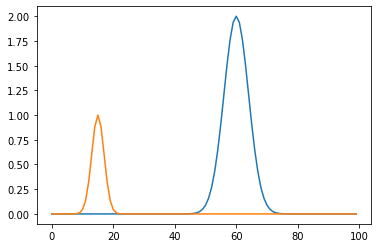

In [28]:
# TEST Code
xs = np.arange(100)
ys = gaussian(xs,a=1,b=15,c=2)+gaussian(xs,a=2,b=60,c=4)
params = fit_gaussians(ys, n=2)
plot_gaussians(xs, params)

In [27]:
params

array([[ 2., 60.,  4.],
       [ 1., 15.,  2.]])